# Tour of mosquito collection sites

In this notebook we'll take a virtual tour of the locations where mosquitoes contributed to Ag1000G phase 3 were collected. We'll plot some maps to see the collection sites in their geographical context. For added interest, we'll also plot some other geographical data on the maps, such as [ecosystem classifications](http://www.aag.org/cs/publications/special/map_african_ecosystems) and data from the [Malaria Atlas Project](https://malariaatlas.org/explorer/#/). 

As always, this notebook is executable, which means you can run it for yourself by clicking the launch icon (<i class="fas fa-rocket"></i>) at the top of the page and selecting one of the cloud computing services available. 

## Setup

To load geographical data and plot maps, we'll need to install some packages, including [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [rasterio](https://rasterio.readthedocs.io/en/latest/). Installing these packages can be a bit fiddly. If you're running this on Google Colab or other Debian/Ubuntu systems and using pip to install Python packages, the following code should do it. Installation commands on other systems may vary.

In [38]:
!apt-get -q install libgdal-dev libproj-dev libgeos-dev
!pip install -q cython numpy scipy pyshp six matplotlib pandas malariagen_data adjustText
!pip uninstall -q -y shapely  # make sure we have a fresh install
!pip install -q shapely --no-binary shapely
!pip install -q --upgrade cartopy
!pip install -q --upgrade rasterio

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
# check we have cartopy 0.18.0 or greater
import cartopy
cartopy.__version__

'0.18.0'

In [3]:
import rasterio
rasterio.__version__

'1.2.0'

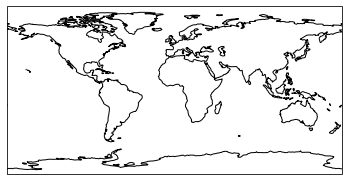

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

In [13]:
# setup access to MalariaGEN data via Google Cloud
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

To plot the extra geographical data, we'll need to download some files. 

The ecosystem classifications in full resolution are available from the [USGS website](http://rmgsc.cr.usgs.gov/outgoing/ecosystems/AfricaData/), but these are large files and higher resolution than we need. For convenience we've precomputed a downsampled version of these data, let's download it.  

In [14]:
!wget --no-clobber https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG_5pc.tif
!wget --no-clobber https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG.tif.vat.csv

File ‘Africa_IVC_20130316_final_MG_5pc.tif’ already there; not retrieving.

File ‘Africa_IVC_20130316_final_MG.tif.vat.csv’ already there; not retrieving.



Data from the Malaria Atlas Project can be downloaded from their [data explorer site](https://malariaatlas.org/explorer/). Let's download the most recent ITN coverage model.

In [15]:
!wget --no-clobber -O 2020_Africa_ITN_Use.zip "https://malariaatlas.org/geoserver/Explorer/ows?service=CSW&version=2.0.1&request=DirectDownload&ResourceId=Explorer:2020_Africa_ITN_Use"
!unzip -n -d 2020_Africa_ITN_Use 2020_Africa_ITN_Use.zip

File ‘2020_Africa_ITN_Use.zip’ already there; not retrieving.
Archive:  2020_Africa_ITN_Use.zip


Now let's define some functions for loading the map data and plotting a map, with support for different background options.

In [40]:
from functools import lru_cache
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM, GoogleTiles
from adjustText import adjust_text

In [17]:
# setup some geographical projections
crs_lonlat = ccrs.PlateCarree()
crs_mercator = ccrs.Mercator()

In [18]:
@lru_cache(maxsize=None)
def load_ecosystems():
    """Load the African ecosystems data."""

    # build a matplotlib colour map from the colour table
    df_colors = pd.read_csv('Africa_IVC_20130316_final_MG.tif.vat.csv').set_index('Value')
    colors = np.zeros((df_colors.index.max() + 1, 3), dtype=float)
    for v, (r, g, b) in df_colors[['Red', 'Green', 'Blue']].iterrows():
        colors[int(v)] = r, g, b
    # fix the zero colour to be white
    colors[0] = 1, 1, 1
    cmap = mpl.colors.ListedColormap(colors)

    # load the image data
    image = rasterio.open("Africa_IVC_20130316_final_MG_5pc.tif")
    image_data = image.read(1)
    image_data = np.ma.masked_where(image_data < 0, image_data)  

    # determine image extent 
    extent = (
        image.bounds.left, 
        image.bounds.right,
        image.bounds.bottom,
        image.bounds.top
    )         

    return image_data, cmap, extent, crs_lonlat


In [19]:
@lru_cache(maxsize=None)
def load_itn_coverage(year):
    """Load ITN coverage data for a given year."""
    
    image = rasterio.open(f"2020_Africa_ITN_Use/2020_GBD2021_Africa_ITN_Coverage_{year}.tif")
    image_data = image.read(1)
    image_data = np.ma.masked_where(image_data <= 0, image_data)
    cmap = "RdYlGn"
    extent = (
        image.bounds.left, 
        image.bounds.right,
        image.bounds.bottom,
        image.bounds.top
    )
    return image_data, cmap, extent, crs_lonlat


In [304]:
def plot_sites(extent=None, sample_sets="v3_wild", sample_query=None, background='osm', 
               bgzoom=3, bgstyle='street', bgyear=2019, ax=None, figsize=(7, 7), gridlines=15,
               plot_kws=None, label_sites=False, title=None):
    """Plot a map of mosquito collection sites."""

    # normalise background parameter to lower case
    background = background.lower()

    if extent is None:
        # default to the whole of Africa
        extent = -26, 64, -35, 38

    # decide what projection to use
    if background in {'osm', 'google'}:
        # these backgrounds use Mercator projection and look best in their
        # native projection
        projection = ccrs.GOOGLE_MERCATOR
    else:
        # other backgrounds use Plate Carree, for simplicity use their
        # native projection
        projection = crs_lonlat
        
    # create a figure and axes to plot on
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=projection)

    # set the extent of the map
    ax.set_extent(extent, crs=crs_lonlat)

    # plot the background image

    if background == 'osm':
        # use OpenStreetMap as background
        imagery = OSM()
        ax.add_image(imagery, bgzoom)

    elif background == 'google':
        # use Google Maps as background
        imagery = GoogleTiles(style=bgstyle)
        ax.add_image(imagery, bgzoom)

    elif background == 'ecosystems':
        # use African Ecosystems as background
        image_data, image_cmap, image_extent, image_crs = load_ecosystems()
        ax.imshow(image_data, cmap=image_cmap, 
                  interpolation='nearest', extent=image_extent,
                  origin='upper', transform=image_crs)
        if title is None:
            title = 'Ecosystems'
        
    elif background == 'itn_coverage':
        # use ITN coverage as background
        image_data, image_cmap, image_extent, image_crs = load_itn_coverage(bgyear)
        ax.imshow(image_data, cmap=image_cmap, 
                  interpolation='nearest', extent=image_extent,
                  origin='upper', transform=image_crs)
        if title is None:
            title = f'ITN coverage ({bgyear})'

    if background in {"ecosystems", "itn_coverage"}:
        # add useful features
        ax.coastlines(resolution='50m', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=1)
        
    if background == 'itn_coverage':
        ax.add_feature(cfeature.LAKES, linewidth=1)

    # draw gridlines
    if gridlines:
        gl = ax.gridlines(crs=crs_lonlat, 
                          xlocs=np.arange(-180, 180, gridlines), 
                          ylocs=np.arange(-180, 180, gridlines), 
                          draw_labels=True)
        gl.top_labels = None
        gl.right_labels = None
        
    if title is not None:
        ax.set_title(title)

    # plot sampling sites
    df_summary = None
    if sample_sets is not None:
        df_samples = ag3.sample_metadata(sample_sets=sample_sets)
        if sample_query is not None:
            df_samples = df_samples.query(sample_query)
        df_sites = df_samples[['location', 'longitude', 'latitude']].drop_duplicates()
        l = df_sites['location']
        x = df_sites['longitude']
        y = df_sites['latitude']
        if plot_kws is None:
            plot_kws = dict()
        plot_kws.setdefault('marker', 'o')
        plot_kws.setdefault('linestyle', ' ')
        plot_kws.setdefault('markeredgecolor', 'k')
        plot_kws.setdefault('markerfacecolor', 'w')
        plot_kws.setdefault('markersize', 6)
        plot_kws.setdefault('markeredgewidth', 1)
        if label_sites:
            # trick to allow us to use the annotate() method
            xycoords = crs_lonlat._as_mpl_transform(ax)
            for t, i, j in zip(l, x, y):
                t = ax.annotate(t, xy=(i, j), xycoords=xycoords, xytext=(0, 5), textcoords='offset points', 
                                ha='center', va='bottom', backgroundcolor=(1, 1, 1, .7))
        ax.plot(x, y, transform=crs_lonlat, zorder=10, **plot_kws)
        
        # build a summary dataframe showing numbers of samples
        df_summary = pd.DataFrame(df_samples.groupby(['sample_set', 'location', 'longitude', 'latitude', 'year', 'species']).size().rename('n_samples'))

    return df_summary

    

Let's try out the map plotting function, with the different backgound options...

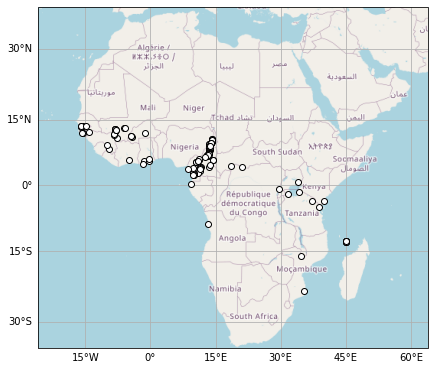

In [305]:
plot_sites(background='osm', bgzoom=3);

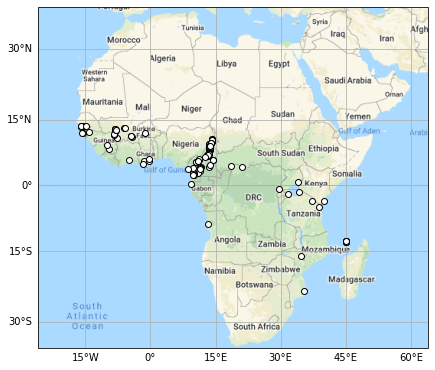

In [288]:
plot_sites(background='google', bgzoom=3, bgstyle='street');

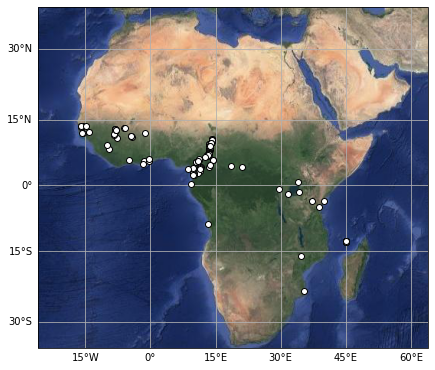

In [289]:
plot_sites(background='google', bgzoom=3, bgstyle='satellite');

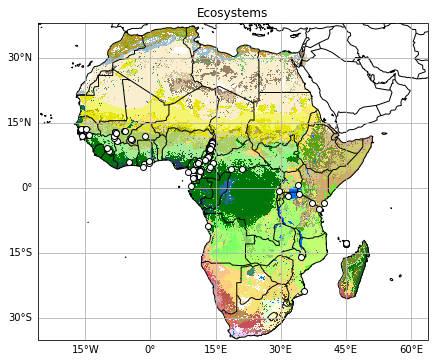

In [290]:
plot_sites(background='ecosystems');

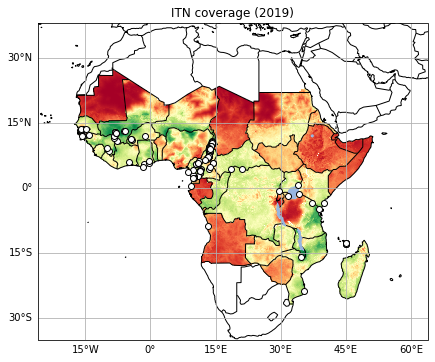

In [291]:
plot_sites(background='itn_coverage', bgyear=2019);

Now let's zoom into some of the different collection sites, starting in East Africa and moving west.

## Mozambique

@@TODO

n_samples
sample_set location longitude latitude year species           
AG1000G-MZ Furvela  35.299    -23.716  2003 gambiae          3
                                       2004 gambiae         71

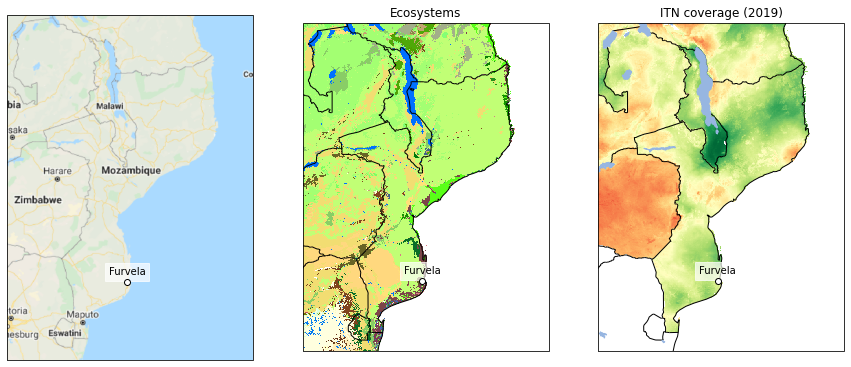

In [306]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(28, 43, -28, -8),
    sample_query='country == "Mozambique"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=5, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Malawi

@@TODO

,,,,,,n_samples
sample_set,location,longitude,latitude,year,species,
AG1000G-MW,Chikhwawa,34.755,-15.933,2015,arabiensis,41


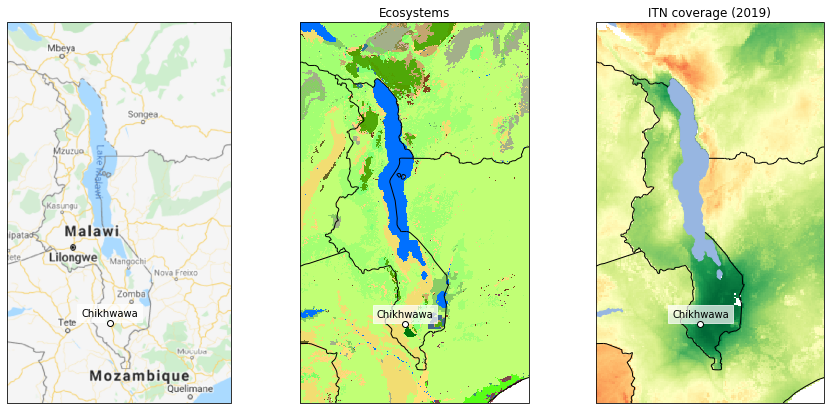

In [307]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(32, 38, -18, -8),
    sample_query='country == "Malawi"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Tanzania

@@TODO

n_samples
sample_set location longitude latitude year species                                 
AG1000G-TZ Moshi    37.308    -3.482   2012 arabiensis                            40
           Muheza   38.948    -4.940   2013 arabiensis                             1
                                            gambiae                               36
                                            intermediate_gambiae_coluzzii          6
           Muleba   31.651    -1.962   2015 arabiensis                           137
                                            gambiae                               32
                                            intermediate_gambiae_coluzzii          1
           Tarime   34.199    -1.431   2012 arabiensis                            47

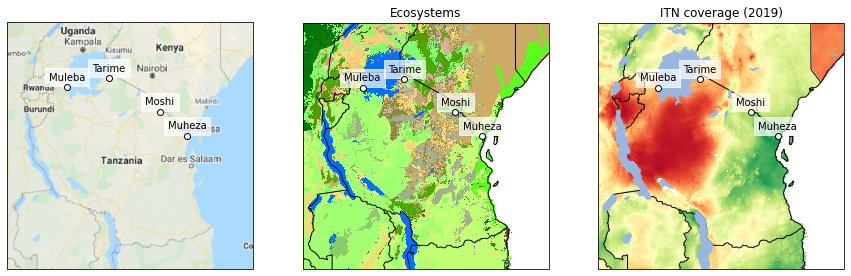

In [308]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(28, 43, -13, 2),
    sample_query='country == "Tanzania"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=5, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Kenya

n_samples
sample_set location longitude latitude year species                                 
AG1000G-KE Kilifi   39.909    -3.511   2000 gambiae                               19
                                       2007 arabiensis                             3
                                       2012 arabiensis                            10
                                            gambiae                                9
                                            intermediate_gambiae_coluzzii         45

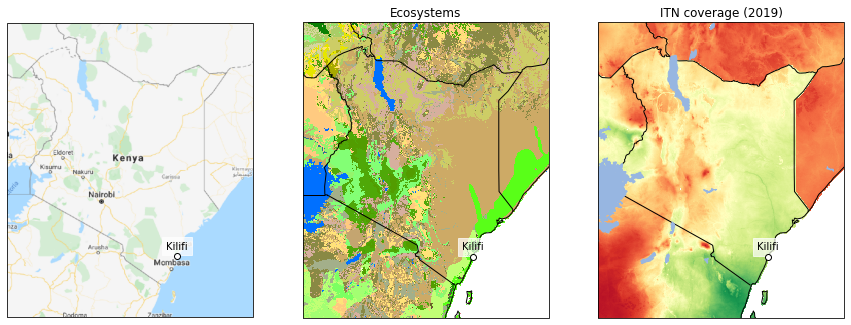

In [309]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(33, 43, -6, 6),
    sample_query='country == "Kenya"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Uganda

@@TODO

n_samples
sample_set location  longitude latitude year species                                   
AG1000G-UG Kihihi    29.701    -0.751   2012 arabiensis                               1
                                             gambiae                                 95
           Nagongera 34.026     0.770   2012 arabiensis                              81
                                             gambiae                                112
                                             intermediate_arabiensis_gambiae          1

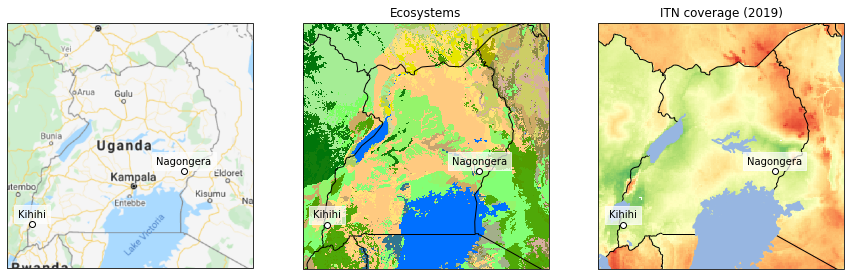

In [310]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(29, 36, -2, 5),
    sample_query='country == "Uganda"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Democratic Republic of the Congo

@@TODO

,,,,,,n_samples
sample_set,location,longitude,latitude,year,species,
AG1000G-CD,Gbadolite,21.017,4.283,2015,gambiae,76


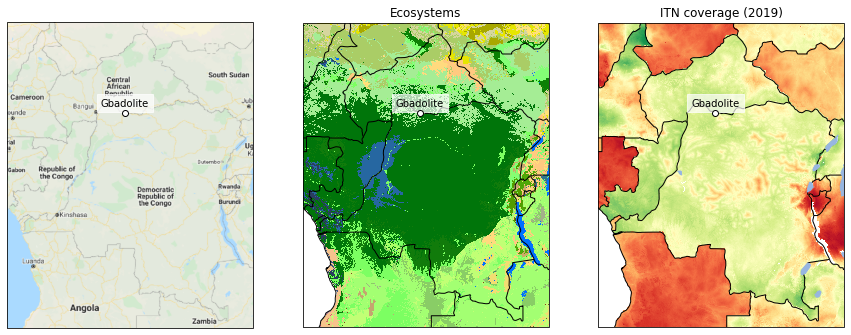

In [311]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(11, 32, -14, 12),
    sample_query='country == "Democratic Republic of Congo"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=5, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Central African Republic

@@TODO

n_samples
sample_set location longitude latitude year species            
AG1000G-CF Bangui   18.583    4.367    1993 coluzzii          5
                                            gambiae           2
                                       1994 coluzzii         13
                                            gambiae          53

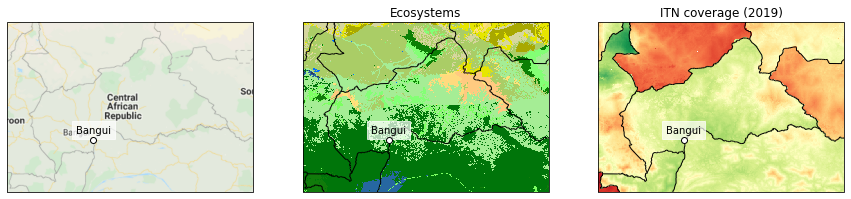

In [312]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(13, 29, 1, 12),
    sample_query='country == "Central African Republic"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=5, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs)

## Cameroon

@@TODO



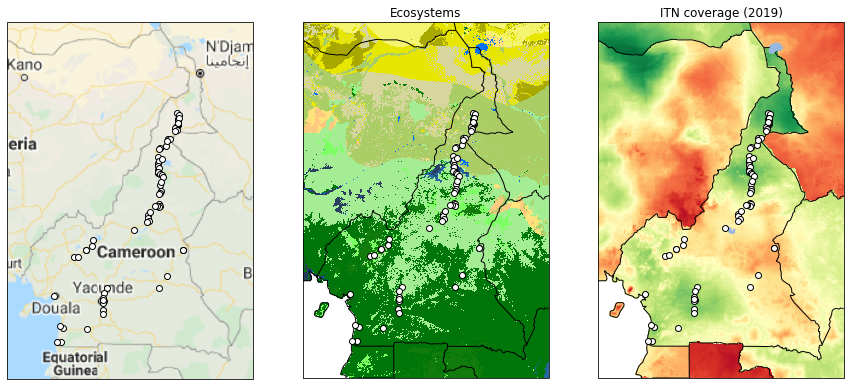

In [313]:
fig = plt.figure(figsize=(15, 7))
kwargs = dict(
    extent=(8, 17, 1, 14),
    sample_query='country == "Cameroon"',
    gridlines=None,
    label_sites=False,
)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=5, ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_sites(background='ecosystems', ax=ax, **kwargs)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_sites(background='itn_coverage', ax=ax, **kwargs);

### AG1000G-CM-C

@@TODO

n_samples
sample_set   location     longitude latitude year species              
AG1000G-CM-C Afan-Essokye 9.983     2.367    2013 gambiae             1
             Campo        9.817     2.367    2013 coluzzii            2
             Douala       9.721     4.055    2013 coluzzii            2
             Lagdo        13.656    9.049    2013 arabiensis          2
                                                  coluzzii            1
             Manchoutvi   11.110    5.880    2013 gambiae             2
             Manda        10.868    5.726    2013 gambiae            11
             Mfelap       10.868    5.726    2013 gambiae             1
             Mgbandji     11.141    6.097    2013 gambiae             1
             Nkolondom    11.516    3.972    2013 coluzzii            5
                                                  gambiae             5
             Tibati       12.629    6.469    2013 coluzzii            2
                                                  gambiae             2
             Yaounde      11.506    3.880    2013 coluzzii            7

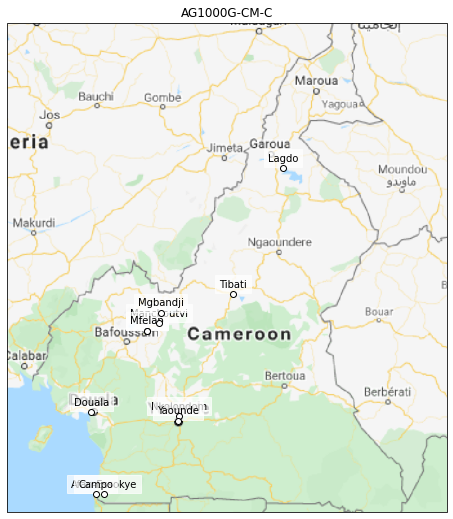

In [314]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8, 17, 2, 12),
    sample_query='country == "Cameroon" and sample_set == "AG1000G-CM-C"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, title="AG1000G-CM-C", **kwargs)

### AG1000G-CM-B

@@TODO

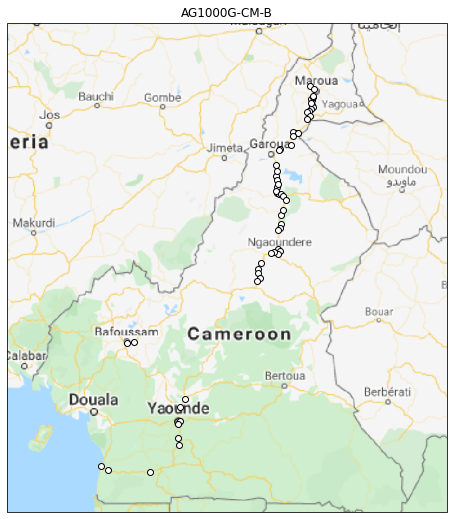

In [315]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8, 17, 2, 12),
    sample_query='country == "Cameroon" and sample_set == "AG1000G-CM-B"',
    gridlines=None,
    label_sites=False,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, title="AG1000G-CM-B", **kwargs);

### AG1000G-CM-A

@@TODO

n_samples
sample_set   location      longitude latitude year species           
AG1000G-CM-A Daiguene      13.844    4.777    2009 gambiae         96
             Gado Badzere  14.442    5.747    2009 gambiae         73
             Mayos         13.558    4.341    2009 gambiae        110
             Zembe Borongo 14.442    5.747    2009 gambiae         24

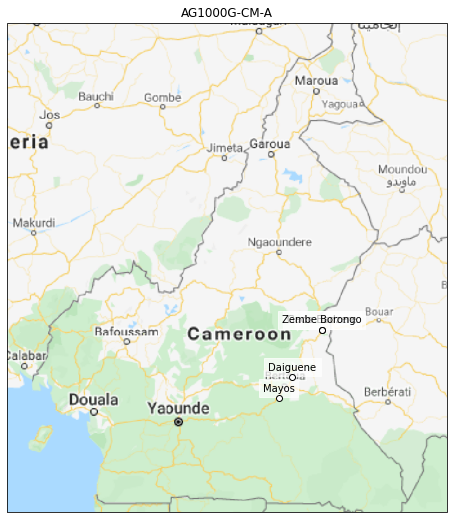

In [316]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8, 17, 2, 12),
    sample_query='country == "Cameroon" and sample_set == "AG1000G-CM-A"',
    gridlines=None,
    label_sites=True,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, title="AG1000G-CM-A", **kwargs)

## Gabon

@@TODO

## Angola

@@TODO

## Ghana

@@TODO

## Cote d'Ivoire

@@TODO

## Burkina Faso

@@TODO

## Mali

@@TODO

## Guinea

@@TODO

## Guinea-Bissau

@@TODO

## The Gambia

@@ TODO

## Mayotte Island

@@TODO

## Bioko Island

@@@TODO
